In [1]:
import pandas as pd, keras as k, numpy as np, matplotlib.pyplot as plt, os, re, glob

import joblib

from scipy.stats import pearsonr

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

In [3]:
# set the korean font for matplotlib
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


In [4]:

# read ./DATA/POST_DATA/all_data.csv
data = pd.read_csv('./POST_DATA/all_data.csv', encoding='cp949', index_col=0, parse_dates=True)

# slice data < 2021-12-31
data = data.loc[:'2019-12-31']

raw_index = data['유해남조류세포수'].dropna(axis=0).index

# interpolate nan values in '유해남조류세포수'
# condition 1 : the period of nan value is less than 14 rows : interpolate nan value with linear method
# condtionn 2 : the period of nan value is more than 14 rows : no action
data['유해남조류세포수'] = data['유해남조류세포수'].interpolate(method='linear', limit=14, limit_direction='both')

# apply log scale to '유해남조류세포수'
data['유해남조류세포수'] = np.log(data['유해남조류세포수'])

# # fill nan values or -inf values with 0 in '유해남조류세포수'
data['유해남조류세포수'] = data['유해남조류세포수'].replace(-np.inf, np.nan)

# make target column
data['유해남조류세포수_Y'] = data['유해남조류세포수'].shift(-1)

# drop column '유해남조류세포수'
# data = data.drop('유해남조류세포수', axis=1)

# calculte % of nan values in each columns of data
nan_df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['% of NaN'])
print(nan_df, '\n',data.shape)

             % of NaN
평균기온        21.535685
최저기온        21.507685
최고기온        21.504573
일강수량        21.485906
최대풍속        21.504573
평균풍속        21.526352
수위_DAY       0.790243
유량_DAY       5.155249
수온          18.925394
용존산소        20.869890
총유기탄소       25.452679
클로로필        20.854334
보방류량_DAY     1.851160
보유입량_DAY     1.866716
보저수량_DAY     0.018667
보저수위_DAY     0.000000
수온_WEK      23.931305
pH_WEK      23.931305
DO_WEK      23.931305
투명도_WEK     91.652666
탁도_WEK      91.652666
Chl-a _WEK  23.931305
유해남조류세포수    46.643022
유해남조류세포수_Y  46.643022 
 (32142, 24)


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# # plot time series of each columns using for loop
# for i in data.columns:
#     plt.figure(figsize=(18,3))
#     plt.plot(data[i], 'ko')
#     plt.title(i)
#     plt.show()


In [6]:
# drop columns if nan is over 30% and apply all columns except '유해남조류세포수_Y'
droprate = 0.30
for i in data.columns:
    if nan_df.loc[i, '% of NaN'] > droprate*100 and i != '유해남조류세포수_Y':
        data = data.drop(i, axis=1)


# # drop columns if nan is over 30%
# droprate = 0.30
# print(data.shape)
# data = data.dropna(axis=1, thresh=len(data)*(1-droprate))
# print(data.shape)

# calculte % of nan values in each columns of data
nan_df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['% of NaN'])
print(nan_df, '\n',data.shape)

             % of NaN
평균기온        21.535685
최저기온        21.507685
최고기온        21.504573
일강수량        21.485906
최대풍속        21.504573
평균풍속        21.526352
수위_DAY       0.790243
유량_DAY       5.155249
수온          18.925394
용존산소        20.869890
총유기탄소       25.452679
클로로필        20.854334
보방류량_DAY     1.851160
보유입량_DAY     1.866716
보저수량_DAY     0.018667
보저수위_DAY     0.000000
수온_WEK      23.931305
pH_WEK      23.931305
DO_WEK      23.931305
Chl-a _WEK  23.931305
유해남조류세포수_Y  46.643022 
 (32142, 21)


In [7]:
x_features = data.iloc[:,:-1].shape[1]
print(x_features)

20


In [8]:
def create_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1): 
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(axis=0, how='any', inplace=True)
    return agg

In [9]:
# input_df is data without '유해남조류세포수'
input_df = data.drop(['유해남조류세포수_Y'], axis=1)
otput_df = data[['유해남조류세포수_Y']]

input_cols = input_df.columns

# normalize features
scaler = StandardScaler()
scaler.fit(input_df)
scaled = scaler.fit_transform(input_df)

# save min, max values
min_values = input_df.min()
max_values = input_df.max()

input_df = pd.DataFrame(scaled, columns=input_df.columns, index=input_df.index)

input_df = create_dataset(input_df, n_in=7, n_out=0, dropnan=False)
otput_df = create_dataset(otput_df, n_in=0, n_out=1, dropnan=False)

model_df = pd.concat([input_df, otput_df], axis=1)
model_df = model_df.loc[raw_index].dropna(axis=0)

#shuffle data
model_df = model_df.sample(frac=1)

print(model_df.shape)

(9420, 141)


In [10]:
X = model_df.iloc[:,:-1].values.reshape(model_df.shape[0], 7, x_features)
y = model_df.iloc[:,-1].values.reshape(model_df.shape[0], 1)

print(X.shape, y.shape)


(9420, 7, 20) (9420, 1)


In [11]:
# train, validation, test 데이터셋으로 분할
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# print all data shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(7536, 7, 20) (7536, 1)
(942, 7, 20) (942, 1)
(942, 7, 20) (942, 1)


In [12]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W1 = self.add_weight(name='W1', shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.W2 = self.add_weight(name='W2', shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.V = self.add_weight(name='V', shape=(self.units,), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        hidden_states = inputs
        score = tf.matmul(hidden_states, self.W1)
        score = tf.tanh(tf.matmul(score, self.W2))
        attention_weights = tf.nn.softmax(tf.matmul(score, tf.reshape(self.V, (-1, 1))), axis=1)
        context_vector = attention_weights * hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(7, X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(Attention(64))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [13]:

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=16, verbose=1, mode='min')

history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

# 모델 평가
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)
mse_test = model.evaluate(X_test, y_test, verbose=0)

print("MSE Train:", mse_train)
print("MSE Validation:", mse_val)
print("MSE Test:", mse_test)

Epoch 1/1000
236/236 - 8s - loss: 7.6698 - val_loss: 2.3606 - 8s/epoch - 35ms/step
Epoch 2/1000
236/236 - 2s - loss: 2.3905 - val_loss: 1.8037 - 2s/epoch - 7ms/step
Epoch 3/1000
236/236 - 2s - loss: 1.9131 - val_loss: 1.5399 - 2s/epoch - 7ms/step
Epoch 4/1000
236/236 - 1s - loss: 1.5579 - val_loss: 1.3414 - 1s/epoch - 6ms/step
Epoch 5/1000
236/236 - 2s - loss: 1.3275 - val_loss: 1.2833 - 2s/epoch - 6ms/step
Epoch 6/1000
236/236 - 2s - loss: 1.1020 - val_loss: 0.9010 - 2s/epoch - 7ms/step
Epoch 7/1000
236/236 - 2s - loss: 0.9436 - val_loss: 0.7496 - 2s/epoch - 7ms/step
Epoch 8/1000
236/236 - 2s - loss: 0.7950 - val_loss: 0.6448 - 2s/epoch - 7ms/step
Epoch 9/1000
236/236 - 2s - loss: 0.6450 - val_loss: 0.5126 - 2s/epoch - 6ms/step
Epoch 10/1000
236/236 - 2s - loss: 0.5634 - val_loss: 0.4556 - 2s/epoch - 6ms/step
Epoch 11/1000
236/236 - 2s - loss: 0.4683 - val_loss: 0.3231 - 2s/epoch - 7ms/step
Epoch 12/1000
236/236 - 2s - loss: 0.4354 - val_loss: 0.2780 - 2s/epoch - 7ms/step
Epoch 13/100

In [14]:
# # save model and scaler using keras library
# model.save('model.h5')

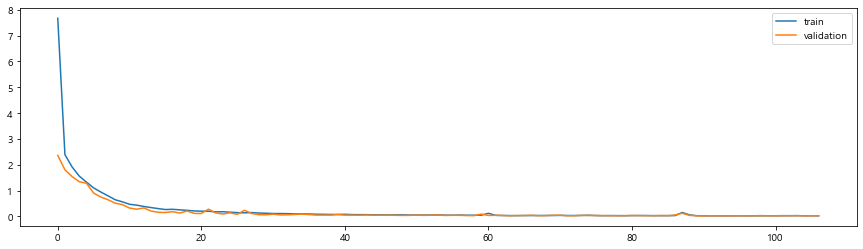

In [15]:
# plot the loss and accuracy
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig('./model_attn/result/loss.png', facecolor='white', dpi=300)
plt.show()
plt.close()



In [16]:
# prediction
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

30/30 [==============================] - 1s 3ms/step


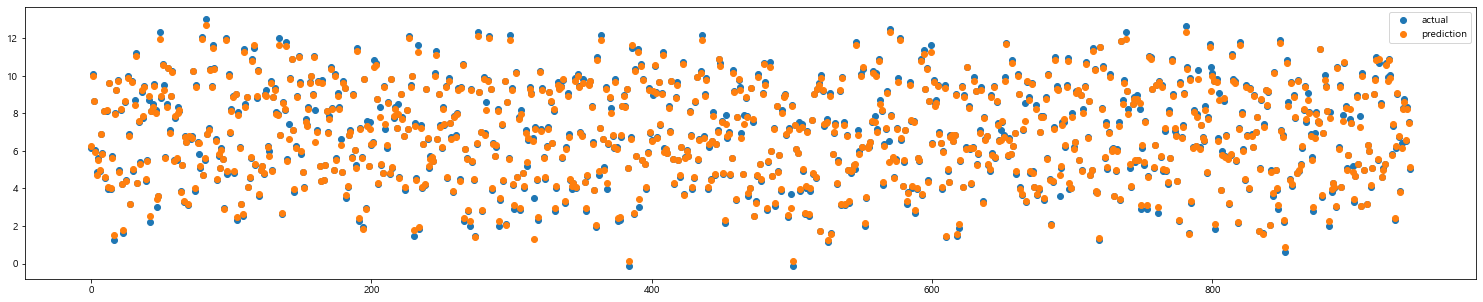

In [17]:
# plot the prediction
fig, ax = plt.subplots(figsize=(26, 5))
plt.plot(y_test, 'o', label='actual')
plt.plot(y_pred, 'o', label='prediction')
plt.legend()
plt.show()

(1096, 20)
(0, 140)
./POST_DATA\낙동강_강정고령.csv
(1096, 20)
(0, 140)
./POST_DATA\낙동강_강정고령보.csv
(1096, 20)
(148, 140)
1/5 [=====>........................] - ETA: 0s

c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


5/5 [==============================] - 0s 3ms/step


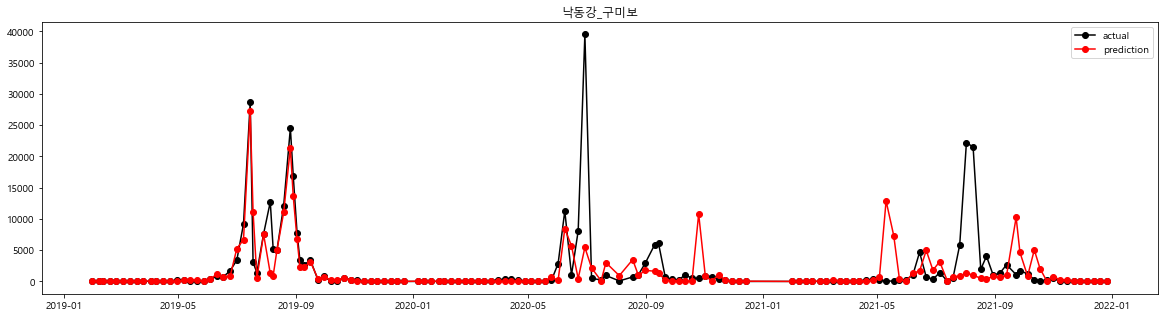

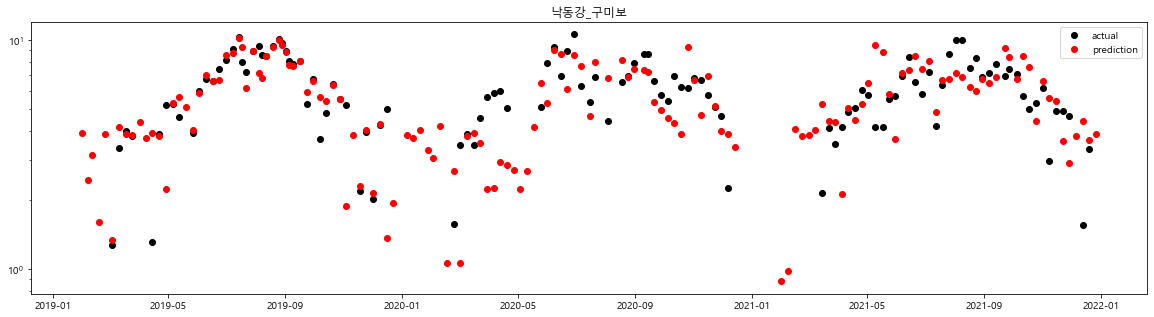

(1096, 20)
(141, 140)
5/5 [==============================] - 0s 3ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


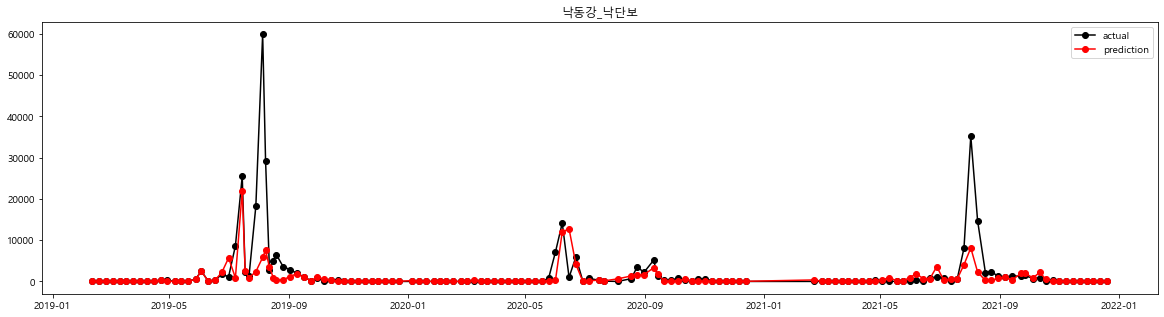

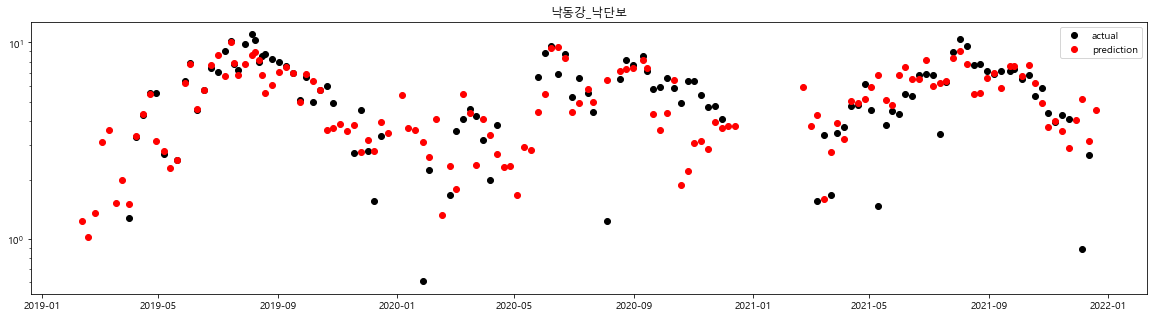

(1096, 20)
(0, 140)
./POST_DATA\낙동강_달성보.csv
(1096, 20)
(84, 140)
3/3 [==============================] - 0s 2ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


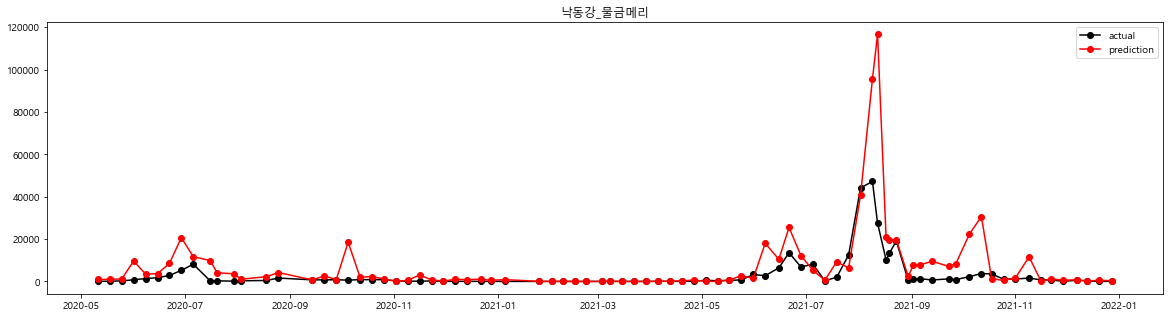

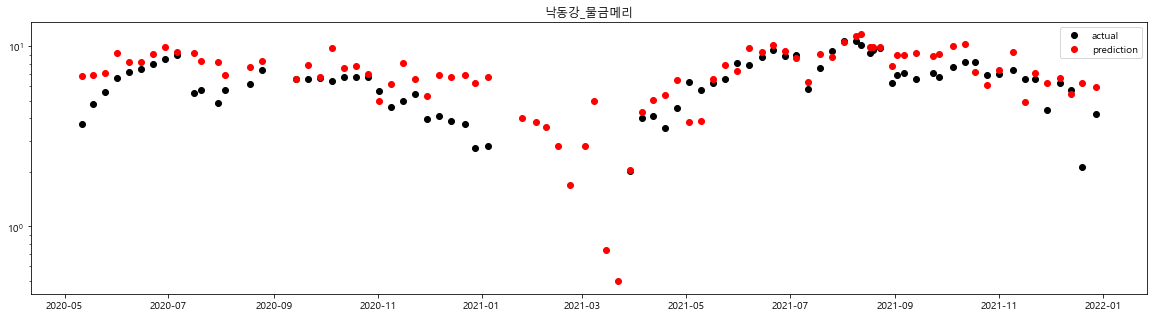

(1096, 20)
(139, 140)
5/5 [==============================] - 0s 3ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


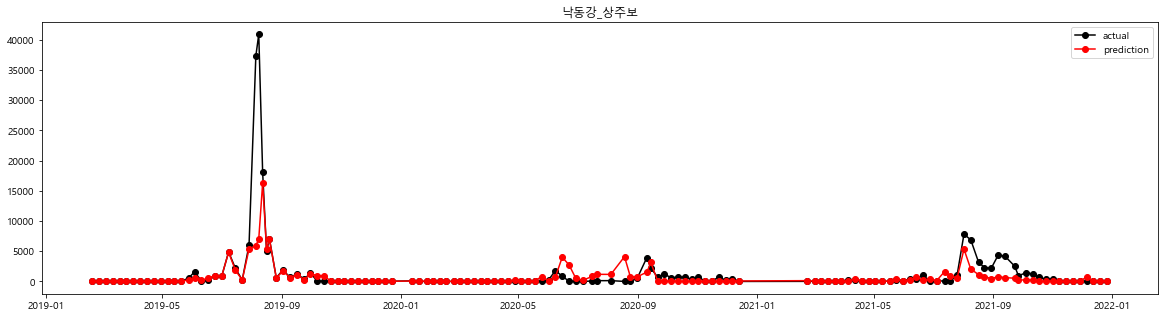

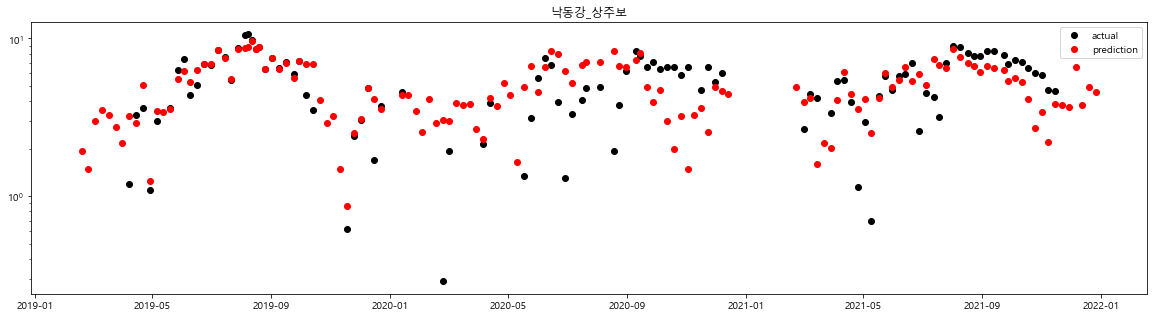

(1096, 20)
(147, 140)
5/5 [==============================] - 0s 3ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


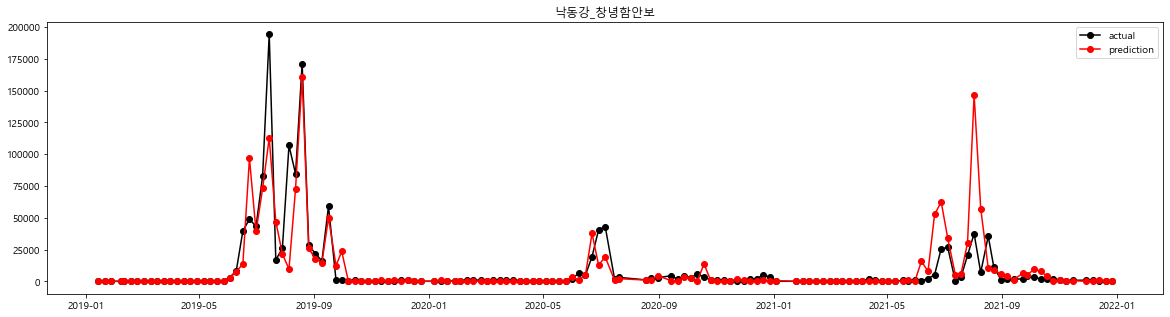

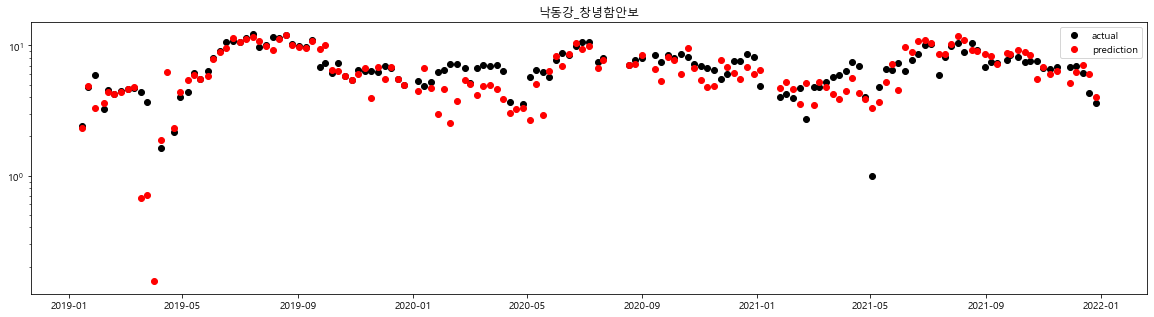

(1096, 20)
(146, 140)
5/5 [==============================] - 0s 3ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


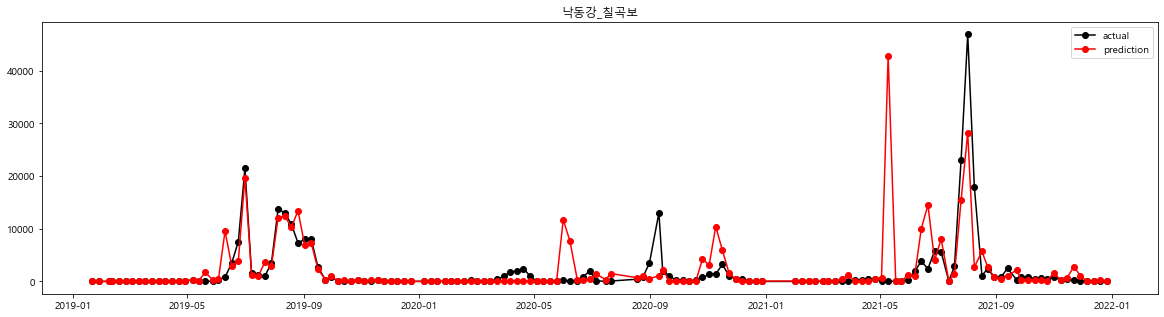

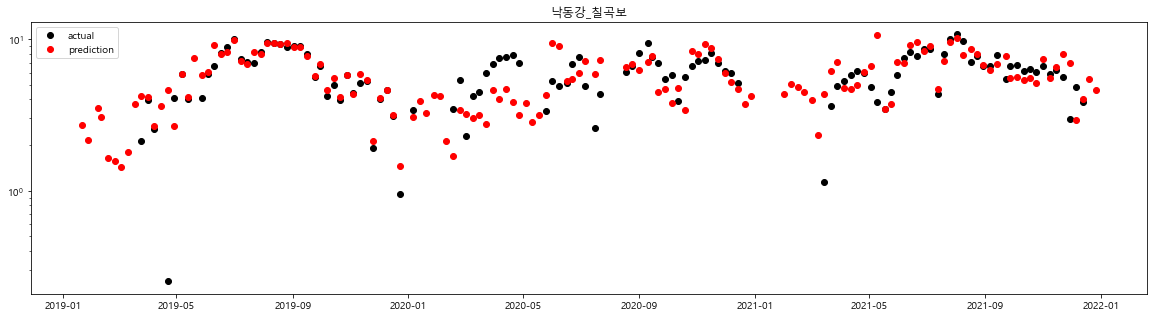

./POST_DATA\낙동강_칠서.csv
(1096, 20)
(165, 140)
6/6 [==============================] - 0s 3ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


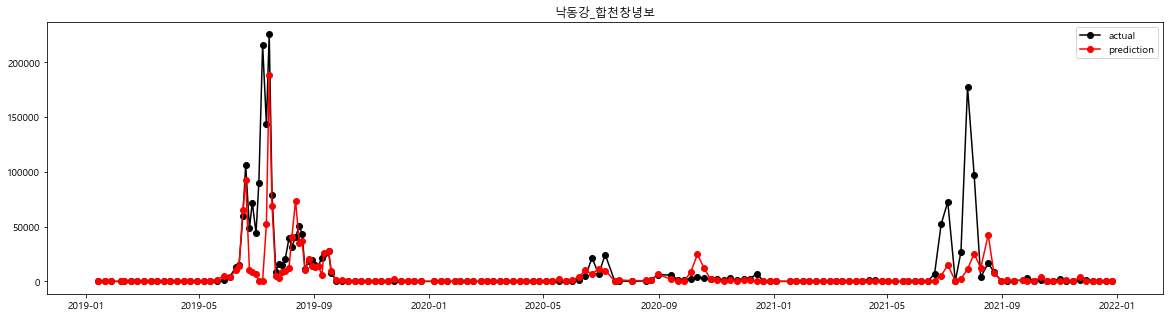

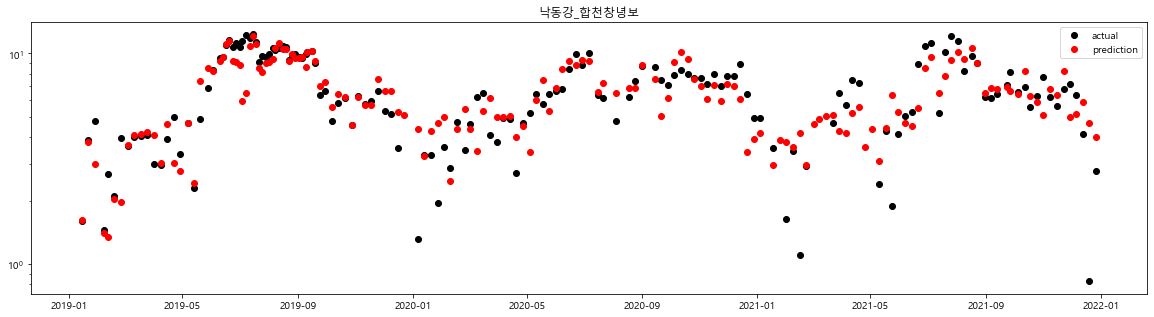

(1096, 20)
(142, 140)
5/5 [==============================] - 0s 3ms/step


c:\Users\ympark\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


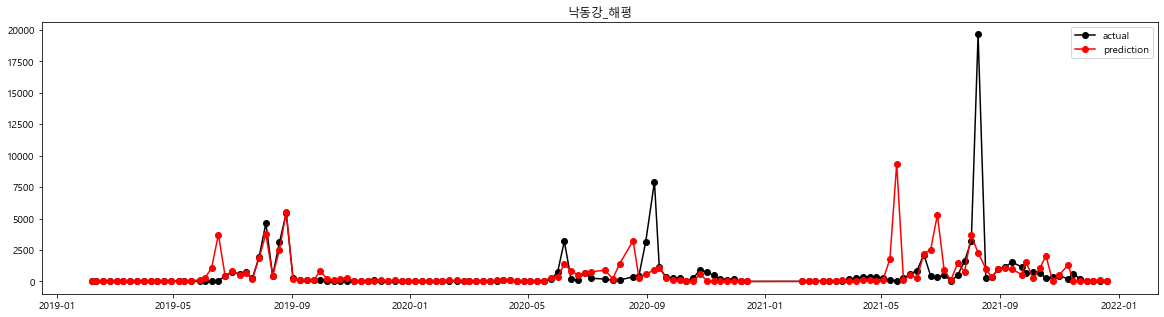

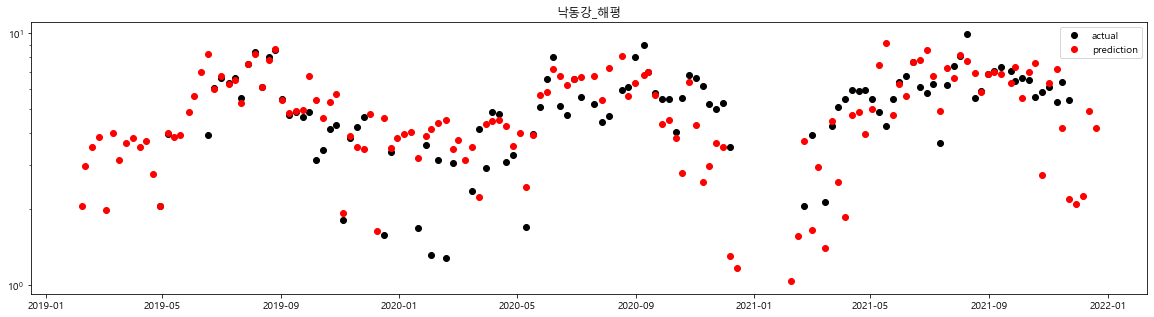

In [18]:
# read post_datas
post_list = glob.glob('./POST_DATA/낙동강*.csv')

for post_path in post_list:

    try:
        point_name = post_path.split('\\')[-1].split('.')[0]
        # read test point data
        test_point_raw = pd.read_csv(post_path, encoding='cp949', index_col=0, parse_dates=True)

        # # slice period over 2023-01-01
        test_point_raw = test_point_raw.loc['2019-01-01':'2021-12-31']

        use_index = test_point_raw['유해남조류세포수'].dropna(axis=0).index

        # interpolate nan values in '유해남조류세포수'
        test_point_raw['유해남조류세포수'] = test_point_raw['유해남조류세포수'].interpolate(method='linear')

        # apply log scale to '유해남조류세포수'
        test_point_raw['유해남조류세포수'] = np.log(test_point_raw['유해남조류세포수'])

        # fill nan values or -inf values with 0 in '유해남조류세포수'
        test_point_raw['유해남조류세포수'] = test_point_raw['유해남조류세포수'].replace(-np.inf, 0)

        # make target column
        test_point_raw['유해남조류세포수_Y'] = test_point_raw['유해남조류세포수'].shift(-1)


        test_point = test_point_raw.copy()
        test_point = test_point[input_cols]

        test_point = test_point.interpolate(method='linear')

        print(test_point.shape)

        test_cols = test_point.columns
        test_indx = test_point.index

        # apply scaler 
        test_scaled = scaler.transform(test_point)

        test_scaled = pd.DataFrame(test_scaled, columns=test_cols, index=test_indx)

        # apply create_dataset function to test point data
        test_point = create_dataset(test_scaled, n_in=7,n_out=0, dropnan=False)
        test_point = test_point.loc[use_index]
        test_point = test_point.dropna(axis=0)
        print(test_point.shape)

        # reshape test point data
        test_point_input = test_point.values.reshape(test_point.shape[0], 7, x_features)

        # predict
        test_point_pred = model.predict(test_point_input)
        test_result = pd.DataFrame(test_point_pred, index=test_point.index, columns=['prediction'])
        rawd_result = test_point_raw.loc[test_point.index, ['유해남조류세포수_Y']]

        # # inverse log
        test_result['prediction_inv'] = test_result['prediction'].apply(lambda x: np.exp(x))
        rawd_result['유해남조류세포수_Y_inv'] = rawd_result['유해남조류세포수_Y'].apply(lambda x: np.exp(x))

        # concat prediction and actual data
        test_result = pd.concat([test_result, rawd_result], axis=1)
        # save prediction and actual data
        test_result.to_csv('./model_attn/result/{}.csv'.format(point_name), encoding='cp949')

        # plot the prediction
        fig, ax = plt.subplots(figsize=(20, 5))
        # ax.set_facecolor('white')
        plt.plot(test_result['유해남조류세포수_Y_inv'], 'ko-', label='actual')
        plt.plot(test_result['prediction_inv'], 'ro-', label='prediction')
        plt.title(point_name)
        plt.legend()

        plt.savefig('./model_attn/result/{}.png'.format(point_name), facecolor='white', dpi=300)

        fig, ax = plt.subplots(figsize=(20, 5))
        # ax.set_facecolor('white')
        plt.plot(test_result['유해남조류세포수_Y'], 'ko', label='actual')
        plt.plot(test_result['prediction'], 'ro', label='prediction')
        plt.title(point_name)
        plt.legend()
        plt.yscale('log')
        plt.savefig('./model_attn/result/{}_log.png'.format(point_name), facecolor='white', dpi=300)
        

        plt.show()
        plt.close()
    except:
        print(post_path)
        pass

In [59]:
test_result.head()

,prediction,prediction_inv,유해남조류세포수_Y,유해남조류세포수_Y_inv
2019-02-07,39.074707,9.331031e+16,0.0,1.0
2019-02-11,6.086317,4.397987e+02,0.0,1.0
2019-02-18,38.532600,5.426199e+16,0.0,1.0
2019-02-25,150.453049,2.192446e+65,0.0,1.0
2019-03-04,164.455292,2.642565e+71,0.0,1.0


In [60]:
# make sestivity analysis method
# 1. if control the input variable each column, the prediction value will be changed by control value.
# 2. If +- control 10% of the each column's value, how much the prediction value will be changed?
# 3. Assessment Methods is correlation coefficient between the prediction value and the control value.

def sensitivity_analysis(model, X_test, y_test, control_value=0.1, n_in=7, n_out=1, x_features=1):
    """
    model: model
    X_test: test input data
    y_test: test target data
    control_value: control value
    n_in: input time step
    n_out: output time step
    x_features: input feature
    """
    # make empty dataframe
    result = pd.DataFrame(columns=['variable', 'corr', 'p_value'])
    
    # make empty list
    corr_list = []
    p_value_list = []
    variable_list = []
    
    # make control value
    control_value = control_value
    
    # make test data
    X_test = X_test
    y_test = y_test
    
    # make test data shape
    test_shape = X_test.shape[0]
    
    # make test data reshape
    X_test = X_test.reshape(test_shape, n_in, x_features)
    
    # make prediction
    y_pred = model.predict(X_test)
    
    # make test data reshape
    X_test = X_test.reshape(test_shape, n_in*x_features)
    
    # make test data dataframe
    X_test = pd.DataFrame(X_test, columns=input_cols)
    
    # make control value dataframe
    control_value_df = X_test.copy()
    
    # make control value dataframe
    for col in X_test.columns:
        control_value_df[col] = control_value_df[col] * control_value
    
    # make control value dataframe
    control_value_df = control_value_df.values.reshape(test_shape, n_in, x_features)
    
    # make control value dataframe
    X_test_control = X_test.values.reshape(test_shape, n_in, x_features)
    
    # make control value dataframe
    X_test_control = X_test_control + control_value_df
    
    # make control value dataframe
    X_test_control = X_test_control.reshape(test_shape, n_in*x_features)
    
    # make control value dataframe
    X_test_control = pd.DataFrame(X_test_control, columns=input_cols)
    
    # make control value dataframe
    X_test_control = X_test_control.values.reshape(test_shape, n_in, x_features)
    
    # make control value dataframe
    y_pred_control = model.predict(X_test_control)
    
    # make control value dataframe
    y_pred_control = y_pred_control.reshape(test_shape, n_out)
    
    # make control value dataframe
    y_pred = y_pred.reshape(test_shape, n_out)
    
    # make control value dataframe
    y_test = y_test.reshape(test_shape, n_out)

    # make control value dataframe
    for col in X_test.columns:
        corr, p_value = pearsonr(y_pred, X_test[col])
        corr_list.append(corr)
        p_value_list.append(p_value)
        variable_list.append(col)

    # make control value dataframe
    result['variable'] = variable_list
    result['corr'] = corr_list
    result['p_value'] = p_value_list

    # make control value dataframe
    return result






In [ ]:
pd.pea